In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, gaussian_remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
import matplotlib as mpl
import cartopy.crs as ccrs
hvplot.output(widget_location='bottom')

# SST bias

In [204]:
# import xarray as xr

# store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/WOA_1degree_monthly-feedstock/woa18-1deg-monthly.zarr'
# ds = xr.open_dataset(store, engine='zarr', chunks={})
#obsT = ds.t_an.isel(depth=0).mean('time').compute()

In [88]:
woa = xr.open_dataset('/vast/pp2681/WOA/woa_1981_2010.nc', decode_times=False)
obsT = woa.t_an.isel(depth=0).isel(time=0)

In [89]:
obsT['lon'] = np.where(obsT['lon']>0, obsT['lon'], 360+obsT['lon'])
obsT = obsT.sortby('lon')

In [90]:
ds_ZB = xr.open_mfdataset('/vast/pp2681/ZB2020/ocean_monthly/*', decode_times=False).isel(time=slice(276,636)) # time slice corresponds to 1981-2010
ds_om4 = xr.open_mfdataset('/vast/pp2681/unparameterized/annual/5yr/*').isel(time=slice(23,48))
om4T = ds_om4.thetao.isel(z_l=0).mean('time').compute()
ZBT = ((ds_ZB.average_DT*ds_ZB.thetao.isel(z_l=0)).sum('time') / ds_ZB.average_DT.sum('time')).compute()

In [185]:
obsT['lon'] = ZBT['lon']
obsT['lat'] = ZBT['lat']

In [220]:
bias_om4 = om4T - obsT
bias_om4 = xr.where(np.isnan(obsT),np.nan,bias_om4)

In [221]:
bias_ZB = ZBT - obsT
bias_ZB = xr.where(np.isnan(bias_om4),np.nan,bias_ZB)

In [222]:
response_ZB = ZBT - om4T
response_ZB = xr.where(np.isnan(bias_om4),np.nan,response_ZB)

In [223]:
fraction = np.abs(bias_ZB)/np.abs(bias_om4)
fraction = xr.where(np.isnan(bias_om4), np.nan, fraction)

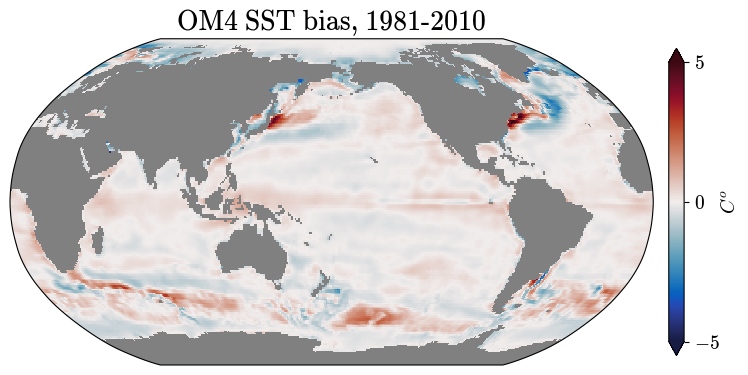

In [154]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = cmocean.cm.balance
cmap.set_bad('gray')
im = bias_om4.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')


cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('OM4 SST bias, 1981-2010', fontsize=20)
plt.savefig('site-visit/OM4-SST-bias-cmocean.pdf', dpi=200)

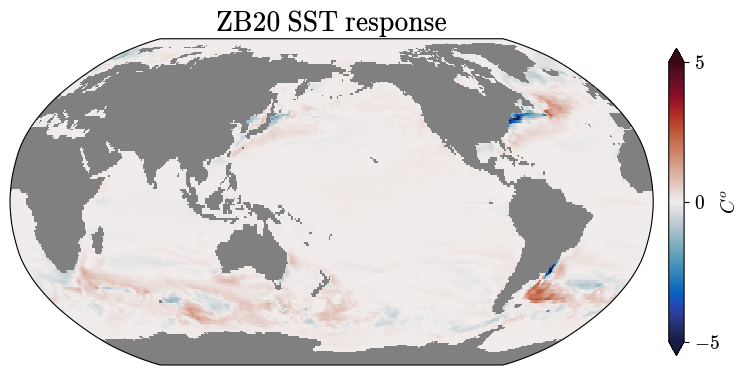

In [155]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
#cmap = plt.get_cmap('seismic')
#cmap.set_bad('gray')
im = response_ZB.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ZB20 SST response', fontsize=20)
plt.savefig('site-visit/ZB-SST-bias-response-cmocean.pdf', dpi=200)

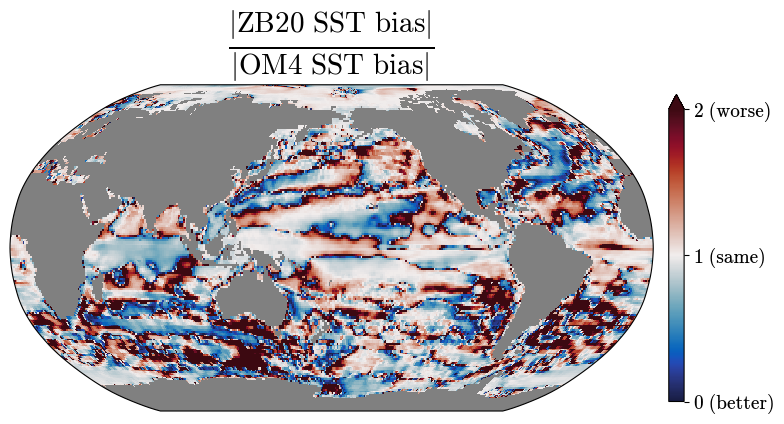

In [247]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = cmocean.cm.balance
cmap.set_bad('gray')
im = fraction.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=0,vmax=2, interpolation='none')


cb = plt.colorbar(im, pad=0.02, ax=axes, extend='max', aspect=20, shrink=0.57)
cb.set_label(label='')
cb.ax.set_yticks([0,1,2], ['0 (better)' , '1 (same)', '2 (worse)'])
plt.title('$\\frac{|\\mathrm{ZB20~ SST~ bias}|}{|\\mathrm{OM4~ SST ~bias}|}$', fontsize=30)
plt.savefig('site-visit/OM4-bias-fraction.pdf', dpi=200)

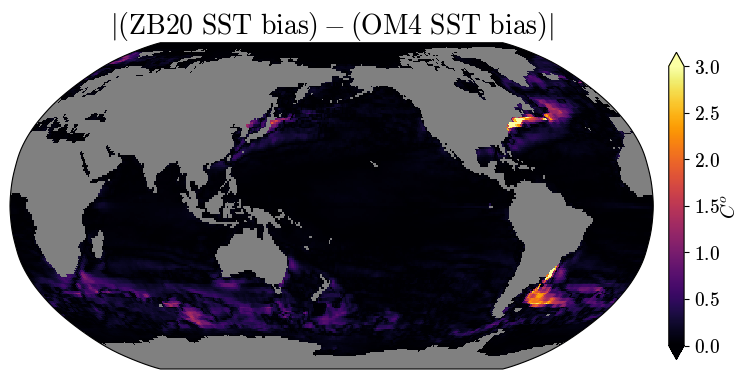

In [259]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = plt.get_cmap('inferno')
cmap.set_bad('gray')
im = (np.abs(bias_om4-bias_ZB)).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=0,vmax=3, interpolation='none')


cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
plt.title('$|(\\mathrm{ZB20~ SST~ bias}) - (\\mathrm{OM4~ SST ~bias})|}$', fontsize=20)
plt.savefig('site-visit/OM4-bias-diff.pdf', dpi=200)

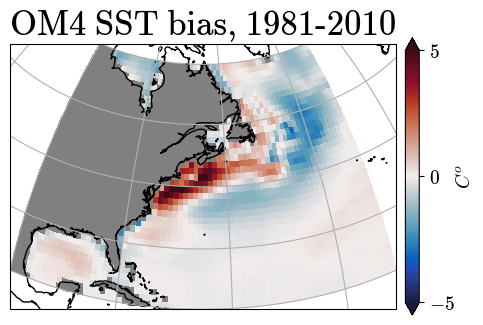

In [156]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
#cmap = plt.get_cmap('seismic')
#cmap.set_bad('gray')
im = bias_om4.sel(lat=lat,lon=lon).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('OM4 SST bias, 1981-2010', fontsize=25)
plt.savefig('site-visit/OM4-SST-bias-Atlantic-cmocean.pdf', dpi=200)

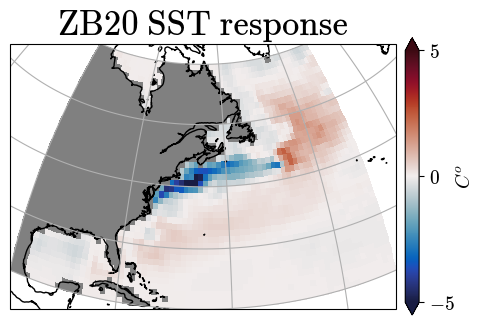

In [157]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
#cmap = plt.get_cmap('seismic')
#cmap.set_bad('gray')
im = response_ZB.sel(lat=lat,lon=lon).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ZB20 SST response', fontsize=25)
plt.savefig('site-visit/ZB-SST-bias-response-Atlantic-cmocean.pdf', dpi=200)

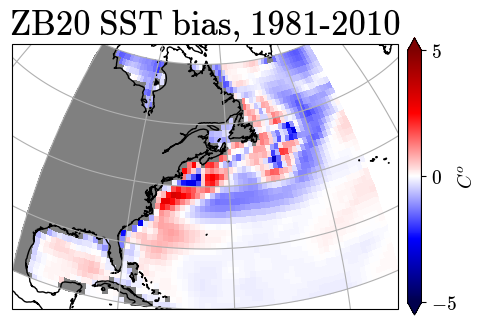

In [202]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
cmap = plt.get_cmap('seismic')
cmap.set_bad('gray')
im = bias_ZB.sel(lat=lat,lon=lon).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ZB20 SST bias, 1981-2010', fontsize=25)
plt.savefig('site-visit/ZB-SST-bias-Atlantic.pdf', dpi=200)